<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module3/TF_Developer_NLP_Module3_Demo1_Analysing_Sentiment_With_OHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Sentiment

## Setup stuff

Let's first import everything and load the dataset

In [1]:
!pip install textblobpip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, Input
import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.nn import leaky_relu
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk

TRACE = False

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Now we will download the dataset and explore it

In [3]:
%%writefile get_data.sh
if [ ! -f yelp.csv ]; then
  wget -O yelp.csv https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
fi

Writing get_data.sh


In [4]:
!bash get_data.sh


--2022-12-23 14:44:32--  https://www.dropbox.com/s/xds4lua69b7okw8/yelp.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xds4lua69b7okw8/yelp.csv [following]
--2022-12-23 14:44:32--  https://www.dropbox.com/s/raw/xds4lua69b7okw8/yelp.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1b2db098705ff079f2e976995d.dl.dropboxusercontent.com/cd/0/inline/BzLyYBRfo9zgylGWPQBYVhsWg4rWBPcjdJzIvMukLJbfd_hVyprhNBVU1srNQ9P6Ul3k-NChWq_lBXRtI8ABUS8Gse-rFPIx_1ONxZZoK9l6cp5Z08eNXzFLhO2fb3ODQR3Ic060ASunYiV0OHPnGkAeNw_1iHEKCClanHChMgfscA/file# [following]
--2022-12-23 14:44:32--  https://uc1b2db098705ff079f2e976995d.dl.dropboxusercontent.com/cd/0/inline/BzLyYBRfo9zgylGWPQBYVhsWg4rWBPcjdJzIvMukLJbfd_hVyprhNBVU1srNQ9P6Ul3k-NChWq_lBXRtI8ABUS8

In [5]:
path = './yelp.csv'
yelp = pd.read_csv(path)
yelp


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0


In [6]:
# Create a new DataFrame that only contains the 5-star and 1-star reviews.
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]
X = yelp_best_worst.text
y = yelp_best_worst.stars.map({1:0, 5:1})


In [7]:
y.value_counts()

1    3337
0     749
Name: stars, dtype: int64

Our dataset is not too imbalanced so we can move on!

## Filtering and creating the corpus

Our first job is to filter the reviews that are too short or have weird characters. One way is using TextBlob although we will see others as we progress

In [8]:
corpus_with_ix = [(ix, ' '.join(TextBlob(sentence).words)) for ix, sentence in X.iteritems() if type(sentence) == str and len(TextBlob(sentence).words) > 3]


In [9]:
corpus_with_ix[0]

(0,
 "My wife took me here on my birthday for breakfast and it was excellent The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning It looked like the place fills up pretty quickly so the earlier you get here the better Do yourself a favor and get their Bloody Mary It was phenomenal and simply the best I 've ever had I 'm pretty sure they only use ingredients from their garden and blend them fresh when you order it It was amazing While EVERYTHING on the menu looks excellent I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete It was the best toast I 've ever had Anyway I ca n't wait to go back")

In [10]:
corpus_df = pd.DataFrame(corpus_with_ix, columns=['index', 'text'])

In [11]:
corpus_df.head()

,index,text
0,0,My wife took me here on my birthday for breakf...
1,1,I have no idea why some people give bad review...
2,3,Rosie Dakota and I LOVE Chaparral Dog Park It ...
3,4,General Manager Scott Petello is a good egg No...
4,6,Drop what you 're doing and drive here After I...


Notice that the index column is not "the same" as the index of the DF, because some sentences are filtered out. Now we need to filter out the corresponding y values

In [12]:
y_filtered = y[corpus_df['index']].to_numpy()

In [13]:
corpus = [sentence for ix, sentence in corpus_with_ix]

In [31]:
corpus[0]

"My wife took me here on my birthday for breakfast and it was excellent The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning It looked like the place fills up pretty quickly so the earlier you get here the better Do yourself a favor and get their Bloody Mary It was phenomenal and simply the best I 've ever had I 'm pretty sure they only use ingredients from their garden and blend them fresh when you order it It was amazing While EVERYTHING on the menu looks excellent I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete It was the best toast I 've ever had Anyway I ca n't wait to go back"

Now we will use Keras tokenizer to construct a vocab and a word to index mapping. In further demos we will change these by embeddings

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
tokenized_corpus = tokenizer.texts_to_sequences(corpus)
tokenized_corpus[0][:6]


[13, 411, 204, 36, 41, 21]

In [33]:
nb_samples = sum(len(s) for s in corpus)
vocab_size = len(tokenizer.word_index) + 1

In [34]:
nb_samples, vocab_size

(2616086, 19331)

Notice we handled 2 million tokens in almost 20K words indexed. 

## Creating the tensor

Now comes the crucial step, we need to PAD out tokenized corpus to construct the tensor. For this we can verify the value 0 is not used for any word

In [39]:
for ix, word in tokenizer.index_word.items():
  print(ix, word)
  if ix > 5:
    break

1 the
2 and
3 i
4 a
5 to
6 of


In [17]:
def get_maximum_review_length(tokenized_corpus):
    maximum = 0
    for sentence in tokenized_corpus:
        candidate = len(sentence)
        if candidate > maximum:
            maximum = candidate
    return maximum
max_review_length = get_maximum_review_length(tokenized_corpus)

In [18]:
final_X = np.zeros((len(tokenized_corpus), max_review_length))
for ix, tokenized_sentence in enumerate(tokenized_corpus):
    tokenized_sentence.extend([0]*(max_review_length-len(tokenized_sentence)))
    final_X[ix] = tokenized_sentence

Finally, we appended 0s at the end to have a proper matrix. Later we will use keras methods to do this

## Doing the train_test split and defining model

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_X, y_filtered, test_size = 0.4, random_state=42)

In [20]:
X_train_tensor = tf.constant(X_train)
X_test_tensor = tf.constant(X_test)
y_train_tensor = tf.constant(y_train)
y_test_tensor = tf.constant(y_test)

In [21]:
X_train_tensor.shape

TensorShape([2433, 933])

In [22]:
model = Sequential()
model.add(Input(shape = (max_review_length,)))
model.add(Dense(100, activation=leaky_relu))
model.add(Dense(50, activation=leaky_relu))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               93400     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 98,501
Trainable params: 98,501
Non-trainable params: 0
_________________________________________________________________


In [42]:
test_point = np.zeros((1, max_review_length))
token_horrible = tokenizer.texts_to_sequences(['Horrible'])[0][0]
token_horrible

565

In [43]:
test_point[0,0] = token_horrible
model(tf.constant(test_point))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.18204656]], dtype=float32)>

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_precision', patience=5, min_delta=0.01, mode="max")
history = model.fit(X_train_tensor, y_train_tensor, epochs = 30, validation_split=0.2, workers = 5, callbacks=[callback])

Epoch 1/30
61/61 [==============================] - 2s 10ms/step - loss: 140.9445 - accuracy: 0.6953 - precision: 0.8206 - recall: 0.8046 - val_loss: 87.4669 - val_accuracy: 0.7125 - val_precision: 0.8155 - val_recall: 0.8321
Epoch 2/30
61/61 [==============================] - 0s 4ms/step - loss: 29.7979 - accuracy: 0.7960 - precision: 0.8717 - recall: 0.8810 - val_loss: 64.2441 - val_accuracy: 0.6345 - val_precision: 0.8028 - val_recall: 0.7252
Epoch 3/30
61/61 [==============================] - 0s 4ms/step - loss: 11.7446 - accuracy: 0.8489 - precision: 0.9105 - recall: 0.9048 - val_loss: 61.7648 - val_accuracy: 0.6838 - val_precision: 0.8072 - val_recall: 0.7990
Epoch 4/30
61/61 [==============================] - 0s 4ms/step - loss: 4.7415 - accuracy: 0.8967 - precision: 0.9352 - recall: 0.9393 - val_loss: 66.3061 - val_accuracy: 0.6899 - val_precision: 0.8040 - val_recall: 0.8142
Epoch 5/30
61/61 [==============================] - 0s 4ms/step - loss: 2.5603 - accuracy: 0.9219 - pre

## Some plots

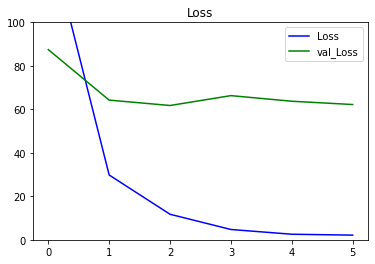

In [44]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=100.0)


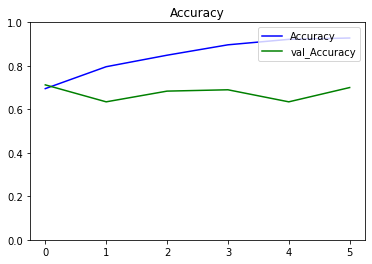

In [27]:
plot_metrics(history.history['accuracy'], history.history['val_accuracy'], "Accuracy", "Accuracy", ylim=1.0)


## Some manual validation

In [54]:
test_point = np.zeros((1, max_review_length))
tokenized_review = tokenizer.texts_to_sequences(['Horrible restaurant'])[0]
tokenized_review.extend([0] * (max_review_length -2))
test_point = np.array([tokenized_review])

In [55]:
test_point.shape

(1, 933)

In [56]:

model.predict(tf.constant(test_point)) < 0.5

1/1 [==============================] - 0s 55ms/step


array([[ True]])

In [65]:
i = np.random.randint(0, X_test_tensor.shape[0])
tokenizer.sequences_to_texts([X_test_tensor[i].numpy()])

["i am a way more frequent visitor of the bell rd location but sometimes i have to travel downtown for work when i do i make my route pass by this place because i have to have dutch bros the guys at the bell location are pretty familiar with me by now but these guys still treat you as if you are there best customer and it 's the best coffee i 've ever had"]

In [66]:
prediction = model.predict(np.array([X_test_tensor[i]])) > 0.5
prediction == y_test_tensor[i]

1/1 [==============================] - 0s 17ms/step


<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>

In [30]:
model.evaluate(X_test_tensor, y_test_tensor)

51/51 [==============================] - 0s 2ms/step - loss: 57.4854 - accuracy: 0.7049 - precision: 0.8145 - recall: 0.8262


[57.48542785644531, 0.7048675417900085, 0.814456045627594, 0.8261526823043823]

Therefore, the model predicts correctly 70% of the reviews, but with 80% precision and recall, so we have a good distribution between positives and negatives